In [1]:
from scripts.VTECDataReader import VTECDataReader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
PTEX_dir = ["/home/fsamaniego/Documents/FCFM/Proyecto TIDs/Data/CMN Files/PTEX/2018",
            "/home/fsamaniego/Documents/FCFM/Proyecto TIDs/Data/CMN Files/PTEX/2019"]

VTECReader = VTECDataReader(PTEX_dir, min_amplitude = 0.0)
VTECReader.read_and_extract_vtec_data()

--Reading Cmn files--
Number of files: 727


100%|██████████| 727/727 [00:25<00:00, 28.67it/s]



--Separate each Cmn file by PRN--


100%|██████████| 727/727 [00:10<00:00, 69.37it/s] 



--Detrend time series by PRN--


100%|██████████| 31/31 [01:35<00:00,  3.09s/it]


In [3]:
min_max_DTEC = {"min":[], "max":[]}

for vtec_series in VTECReader.dtec_sequences:
    min_max_DTEC["min"].append( abs(vtec_series.min()) )
    min_max_DTEC["max"].append( vtec_series.max() )

sorted_min_dtec_values = np.array(sorted(min_max_DTEC["min"]))
sorted_max_dtec_values = np.array(sorted(min_max_DTEC["max"]))

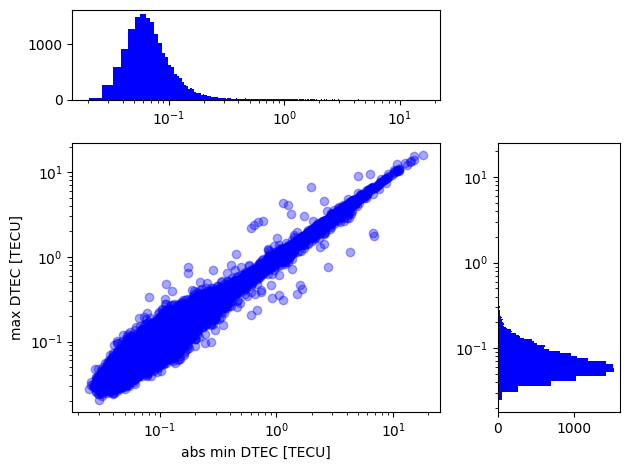

In [4]:
FigureScatter, SubplotsScatter = plt.subplot_mosaic([["HistMax", "."], ["Scatter", "HistMin"]], width_ratios = [3, 1], height_ratios = [1, 3])

SubplotsScatter["Scatter"].scatter(min_max_DTEC["min"], min_max_DTEC["max"], marker = 'o', fc = "blue", alpha = 0.35)
SubplotsScatter["Scatter"].set_xscale("log")
SubplotsScatter["Scatter"].set_yscale("log")
SubplotsScatter["Scatter"].set_xlabel("abs min DTEC [TECU]")
SubplotsScatter["Scatter"].set_ylabel("max DTEC [TECU]")

SubplotsScatter["HistMin"].hist(min_max_DTEC["min"], bins = "auto", orientation="horizontal", color = "blue")
SubplotsScatter["HistMin"].set_yscale("log")
SubplotsScatter["HistMax"].hist(min_max_DTEC["max"], bins = "auto", color = "blue")
SubplotsScatter["HistMax"].set_xscale("log")

FigureScatter.tight_layout()

plt.show()

In [5]:
N_min = sorted_min_dtec_values.size
N_max = sorted_min_dtec_values.size

sum_indicator_min = np.array([ (n + 1)/N_min for n in range(N_min)])
sum_indicator_max = np.array([ (n + 1)/N_max for n in range(N_max)])

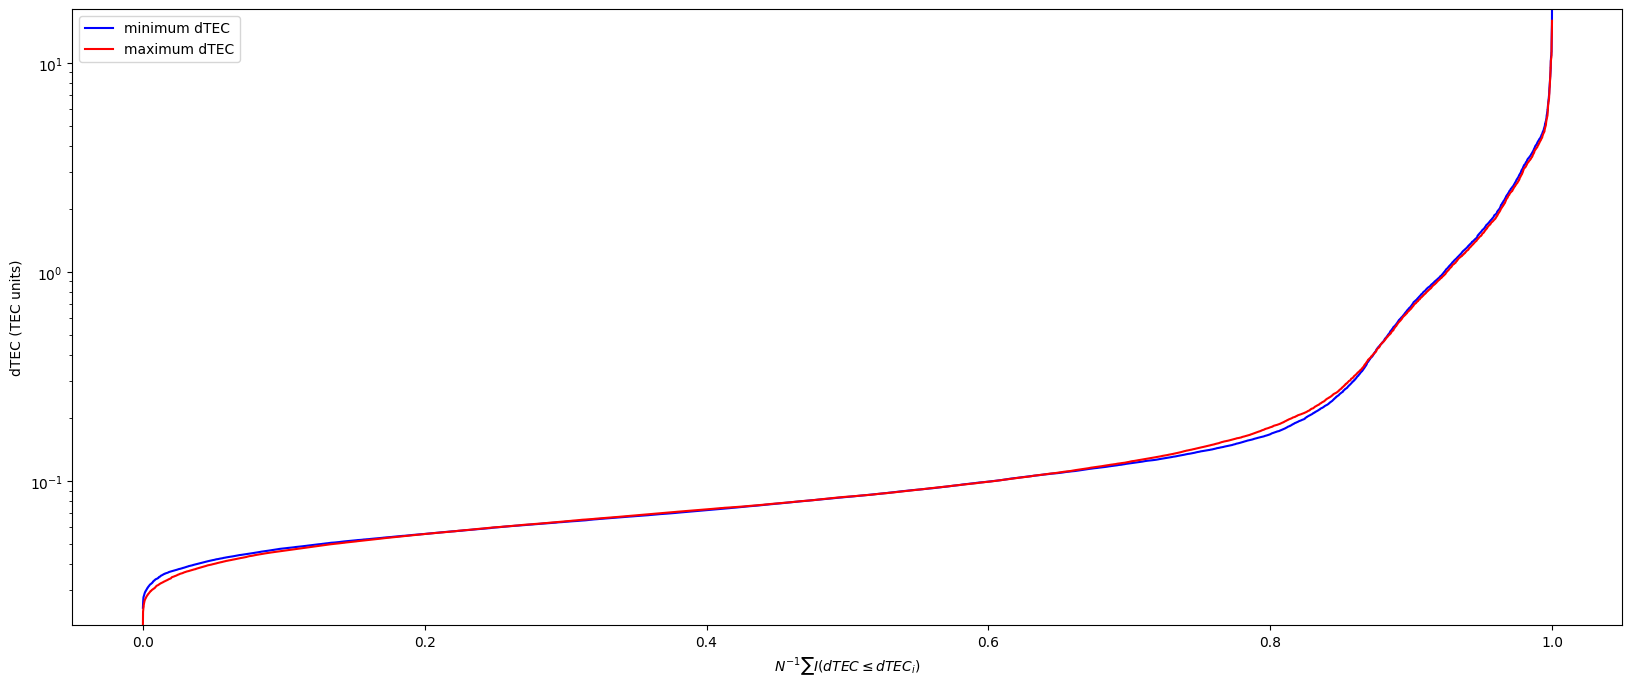

In [6]:
Figure, Subplots = plt.subplots(ncols = 1, nrows = 1, figsize = (20, 8))

y_min, y_max = min(sorted_min_dtec_values.min(), sorted_max_dtec_values.min()), max(sorted_min_dtec_values.max(), sorted_max_dtec_values.max())

Subplots.plot(sum_indicator_min, sorted_min_dtec_values, label = "minimum dTEC", color = "blue")
Subplots.plot(sum_indicator_max, sorted_max_dtec_values, label = "maximum dTEC", color = "red")

Subplots.set_xlabel(r"$N^{-1}\sum I\left(dTEC \leq dTEC_{i}\right)$")
Subplots.set_ylabel("dTEC (TEC units)")
Subplots.set_ylim(y_min, y_max)
Subplots.set_yscale("log")
Subplots.legend()

plt.show()

In [7]:
def calculate_curvature(y, x=None):
    """
    Calculate the curvature (κ) of a curve defined by the points y(x).
    
    Parameters:
    y (numpy array): Array of y-values.
    x (numpy array, optional): Array of x-values. If not provided, assumes uniform spacing.
    
    Returns:
    curvature (numpy array): Curvature values along the curve.
    """
    # If no x is provided, assume uniform spacing
    if x is None:
        x = np.arange(len(y))
    
    # Calculate first derivative (y')
    dy_dx = np.gradient(y, x)
    
    # Calculate second derivative (y'')
    d2y_dx2 = np.gradient(dy_dx, x)
    
    # Calculate curvature (κ)
    curvature = np.abs(d2y_dx2) / (1 + dy_dx**2)**(3/2)
    
    return curvature

In [8]:
def rolling_average(y, window_size):
    """
    Calculate the rolling average (moving average) of a 1D array.

    Parameters:
    y (numpy array): Array of y-values to smooth.
    window_size (int): The size of the rolling window.

    Returns:
    smoothed_y (numpy array): Smoothed y-values with the rolling average applied.
    """
    # Use np.convolve for efficient moving average calculation
    window = np.ones(int(window_size)) / float(window_size)
    smoothed_y = np.convolve(y, window, 'same')  # 'same' to keep the same length as y
    
    return smoothed_y


In [9]:
smooth_min_dtec = rolling_average(sorted_min_dtec_values, 15)
smooth_max_dtec = rolling_average(sorted_max_dtec_values, 15)

curvature_min_dtec = calculate_curvature(smooth_min_dtec, sum_indicator_min)
curvature_max_dtec = calculate_curvature(smooth_max_dtec, sum_indicator_max)

smooth_curvature_min_dtec = rolling_average(curvature_min_dtec, 15)
smooth_curvature_max_dtec = rolling_average(curvature_max_dtec, 15)

In [10]:
def KernelRegression(X, Y, h, Kernel):
    X_reshape = X.reshape((1, X.size))

    ValsKernel = Kernel((X_reshape - X_reshape.T)/h)
    Y_regression = (Y * ValsKernel).sum(axis = 1)/ValsKernel.sum(axis = 1)
    return Y_regression

In [11]:
NormKernel = lambda u: ((2.0 * np.pi) ** -0.5) * np.exp(-0.5 * u * u)

fit_smooth_curvature_min = KernelRegression(sum_indicator_min, smooth_curvature_min_dtec, 1e-2, NormKernel)
fit_smooth_curvature_max = KernelRegression(sum_indicator_max, smooth_curvature_max_dtec, 1e-2, NormKernel)

min_maxfit_index = np.argmax(fit_smooth_curvature_min)
max_maxfit_index = np.argmax(fit_smooth_curvature_max)

min_xfit = sum_indicator_min[min_maxfit_index]
max_xfit = sum_indicator_max[max_maxfit_index]
min_yfit = fit_smooth_curvature_min[min_maxfit_index]
max_yfit = fit_smooth_curvature_max[max_maxfit_index]

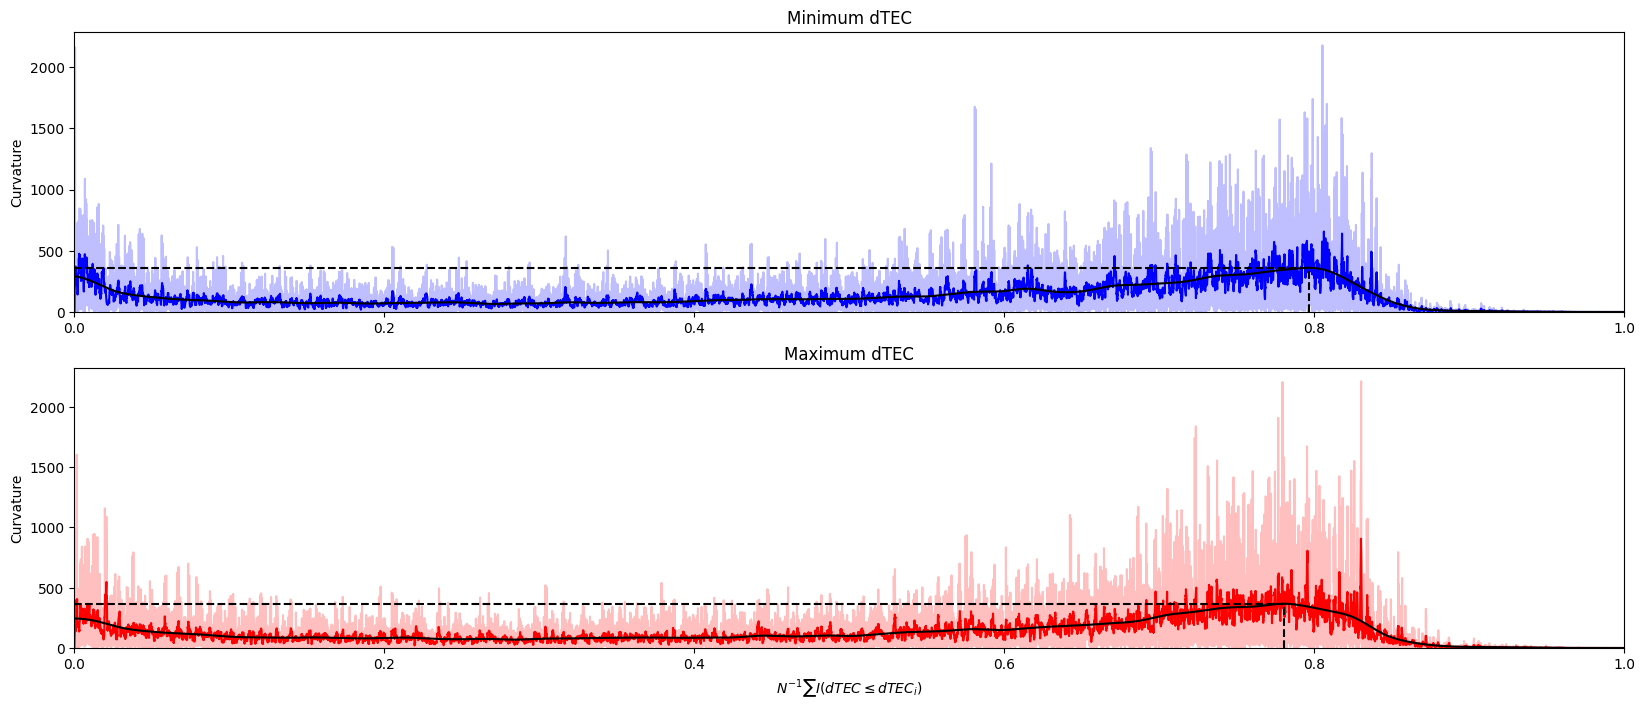

In [12]:
Figure, Subplots = plt.subplots(ncols = 1, nrows = 2, sharex = "row", figsize = (20, 8))

Subplots[0].set_title(label = "Minimum dTEC")
Subplots[0].plot(sum_indicator_min, curvature_min_dtec, color = "blue", alpha = 0.25)
Subplots[0].plot(sum_indicator_min, smooth_curvature_min_dtec, color = "blue")
Subplots[0].plot(sum_indicator_min, fit_smooth_curvature_min, color = "black")
Subplots[0].plot([0.0, min_xfit], 2*[min_yfit], "--k")
Subplots[0].plot(2*[min_xfit], [0.0, min_yfit], "--k")

Subplots[1].set_title(label = "Maximum dTEC")
Subplots[1].plot(sum_indicator_max, curvature_max_dtec, color = "red", alpha = 0.25)
Subplots[1].plot(sum_indicator_max, smooth_curvature_max_dtec, color = "red")
Subplots[1].plot(sum_indicator_max, fit_smooth_curvature_max, color = "black")
Subplots[1].plot([0.0, max_xfit], 2*[max_yfit], "--k")
Subplots[1].plot(2*[max_xfit], [0.0, max_yfit], "--k")

Subplots[0].set_xlim(0.0, 1.0)
Subplots[0].set_ylim(0.0)
Subplots[1].set_xlim(0.0, 1.0)
Subplots[1].set_ylim(0.0)

Subplots[1].set_xlabel(r"$N^{-1}\sum I\left(dTEC \leq dTEC_{i}\right)$")
Subplots[0].set_ylabel("Curvature")
Subplots[1].set_ylabel("Curvature")

plt.show()

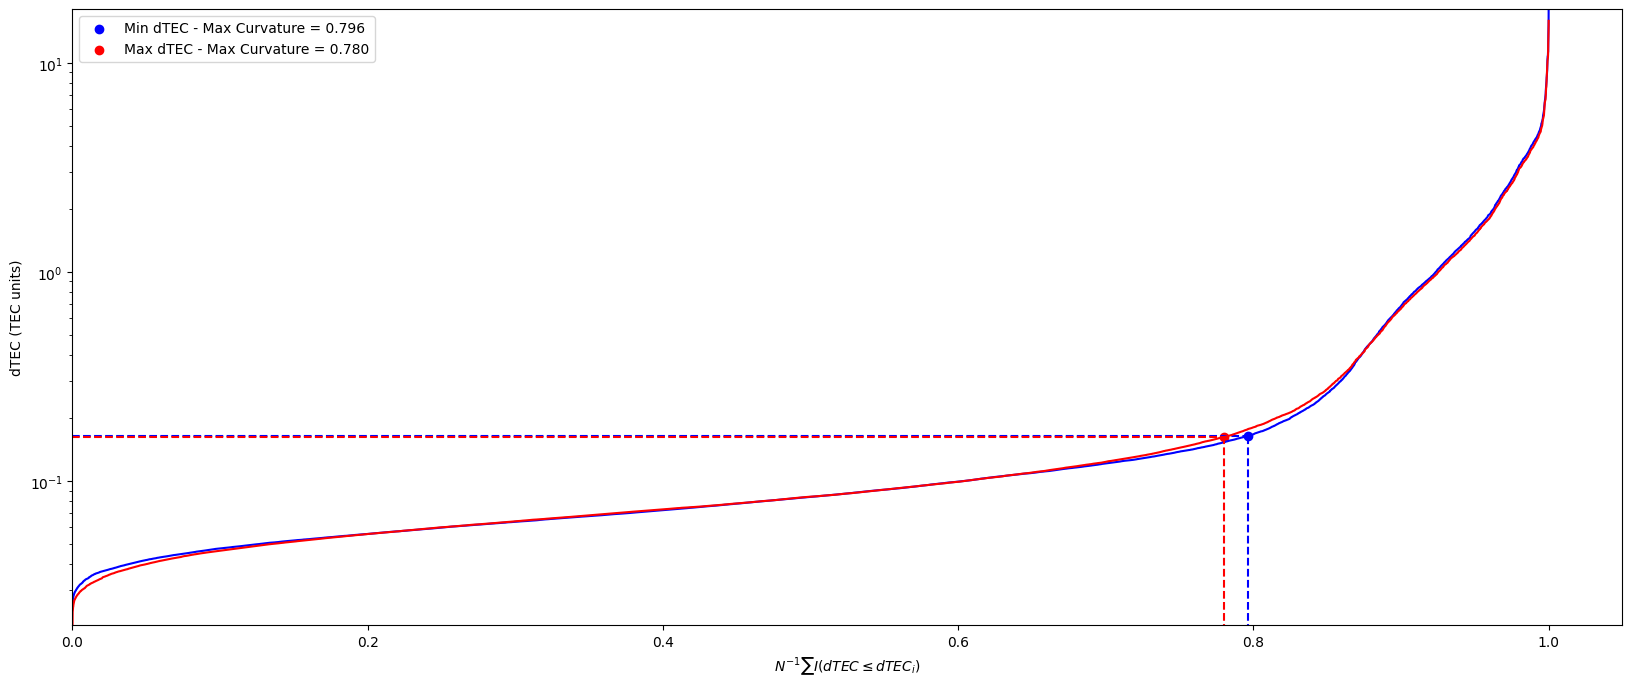

Optimal amplitude threshold for min amplitudes =  0.16425432774689064
Optimal amplitude threshold for max amplitudes =  0.1622449545280169
Mean of optimal amplitude threshold =  0.16324964113745377


In [13]:
Figure, Subplots = plt.subplots(ncols = 1, nrows = 1, figsize = (20, 8))

y_min, y_max = min(sorted_min_dtec_values.min(), sorted_max_dtec_values.min()), max(sorted_min_dtec_values.max(), sorted_max_dtec_values.max())
optimal_mindtec_amp_threshold = sorted_min_dtec_values[min_maxfit_index]
optimal_maxdtec_amp_threshold = sorted_max_dtec_values[max_maxfit_index]

Subplots.plot(sum_indicator_min, sorted_min_dtec_values, color = "blue")
Subplots.scatter(min_xfit, sorted_min_dtec_values[min_maxfit_index], label = f"Min dTEC - Max Curvature = {min_xfit:.3f}", color = "blue")
Subplots.plot([0.0, min_xfit], 2*[optimal_mindtec_amp_threshold], "--b")
Subplots.plot(2*[min_xfit], [0.0, optimal_mindtec_amp_threshold], "--b")

Subplots.plot(sum_indicator_max, sorted_max_dtec_values, color = "red")
Subplots.scatter(max_xfit, sorted_max_dtec_values[max_maxfit_index], label = f"Max dTEC - Max Curvature = {max_xfit:.3f}", color = "red")
Subplots.plot([0.0, max_xfit], 2*[optimal_maxdtec_amp_threshold], "--r")
Subplots.plot(2*[max_xfit], [0.0, optimal_maxdtec_amp_threshold], "--r")

Subplots.set_ylim(y_min, y_max)
Subplots.set_xlim(0.0)

Subplots.set_xlabel(r"$N^{-1}\sum I\left(dTEC \leq dTEC_{i}\right)$")
Subplots.set_ylabel("dTEC (TEC units)")
Subplots.set_yscale("log")
Subplots.legend()

plt.show()

print("Optimal amplitude threshold for min amplitudes = ", optimal_mindtec_amp_threshold)
print("Optimal amplitude threshold for max amplitudes = ", optimal_maxdtec_amp_threshold)
print("Mean of optimal amplitude threshold = ", 0.5*(optimal_mindtec_amp_threshold + optimal_maxdtec_amp_threshold))